<a href="https://colab.research.google.com/github/musab-r/Computational_Intelligence_Project/blob/main/Phase%203%20ANFIS/ANFIS_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Intelligence Project: Sentiment Analysis on IMDB dataset (Part III) 

[Musab - 19030008]

In this Notebook, I have done implementing Hybrid Neuro Genetic Fuzzy System.  In this approach, an optimization is applied to Neuro-fuzzy inference system using genetic algorithm. Neuro-fuzzy is also called ANFIS. Genetic Algorithm is used to optimize the hybrid model using different parameters i.e., 
1. Number of layers
2. Number of parameters in Dense Layer specificly.
3. Different optimizers i.e., Adam, RMSProp,Adagrad, SDG 
4. Different Activation Functions i.e., Sigmoid, Relu 

## Imports

In [ ]:
#%%
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist, imdb
import numpy as np
from keras import regularizers
import matplotlib.pyplot as plt
from FuzzyLayer import FuzzyLayer
from tensorflow.python.client import device_lib
from keras.utils import to_categorical
import re


## Step 1| Loading Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Dataset statistics

In [ ]:
print("train_data ", x_train.shape)
print("train_labels ", y_train.shape)
print("_"*100)
print("test_data ", x_test.shape)
print("test_labels ", y_test.shape)
print("_"*100)
print("Maximum value of a word index ")
print(max([max(sequence) for sequence in x_train]))
print("Maximum length num words of review in train ")
print(max([len(sequence) for sequence in x_train]))

train_data  (25000,)
train_labels  (25000,)
____________________________________________________________________________________________________
test_data  (25000,)
test_labels  (25000,)
____________________________________________________________________________________________________
Maximum value of a word index 
9999
Maximum length num words of review in train 
2494


Vectorizing the input makes the learning of model faster that's why i have applied Vectorization

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

## Step 2| Splitting Dataset

As dataset contains the 50,000 reviews and is classified to positive and negative classes. Genetic Algorithm expands the training as it tries multiple generation, and population to ooptimize the network.   

In [ ]:
x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (25000, 10000)
x_test  (25000, 10000)


In [ ]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

y_train  (25000,)
y_test  (25000,)


In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

print("x_val ", x_val.shape)
print("partial_x_train ", partial_x_train.shape)
print("y_val ", y_val.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (10000, 10000)
partial_x_train  (15000, 10000)
y_val  (10000,)
partial_y_train  (15000,)


## Step 3| Fuzzy System & Neural Network

### Fuzzy Layer | Custom layer

In [ ]:
class FuzzyLayer(Layer):

    def __init__(self, 
                 output_dim, 
                 initializer_centers=None,
                 initializer_sigmas=None, 
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        self.output_dim = output_dim
        self.initializer_centers = initializer_centers
        self.initializer_sigmas = initializer_sigmas
        super(FuzzyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_dimensions = list(input_shape)[:-1:-1]
        self.c = self.add_weight(name='c', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer= self.initializer_centers if self.initializer_centers is not None else 'uniform',
                                 trainable=True)
        self.a = self.add_weight(name='a', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer=self.initializer_sigmas if self.initializer_sigmas is not None else 'ones',
                                 trainable=True)
        super(FuzzyLayer, self).build(input_shape)  

    def call(self, x):
        
        aligned_x = K.repeat_elements(K.expand_dims(x, axis = -1), self.output_dim, -1)
        aligned_c = self.c
        aligned_a = self.a
        for dim in self.input_dimensions:
            aligned_c = K.repeat_elements(K.expand_dims(aligned_c, 0), dim, 0)
            aligned_a = K.repeat_elements(K.expand_dims(aligned_a, 0), dim, 0)

        xc = K.exp(-K.sum(K.square((aligned_x - aligned_c) / (2 * aligned_a)), axis=-2, keepdims=False))
        #sums = K.sum(xc,axis=-1,keepdims=True)
        #less = K.ones_like(sums) * K.epsilon()
        return xc# xc / K.maximum(sums, less)
        
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.output_dim,)

### Neural Network

In [ ]:
input_img = Input(shape=(10000,))
model = Dense(256, kernel_regularizer=regularizers.l1(0.0001), activation='relu')(input_img)
model = Dense(2,activation='relu')(model)
f_layer = FuzzyLayer(100)
model = f_layer(model)
model = Dense(1, activation='linear')(model)
imdb = Model(input_img, model)

In [ ]:
imdb.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 256)               2560256   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
_________________________________________________________________
fuzzy_layer (FuzzyLayer)     (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,561,271
Trainable params: 2,561,271
Non-trainable params: 0
_________________________________________________________________


In [ ]:
imdb.compile(optimizer='sgd', loss='mse',metrics=['acc'])

### Training

In [ ]:
imdb.fit(x_train, y_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_val, y_val))

#%%
weights = f_layer.get_weights()

Epoch 1/10
391/391 [==============================] - 2s 6ms/step - loss: 0.8652 - acc: 0.9521 - val_loss: 0.8380 - val_acc: 0.9539
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 0.8159 - acc: 0.9516 - val_loss: 0.7835 - val_acc: 0.9658
Epoch 3/10
391/391 [==============================] - 2s 5ms/step - loss: 0.7686 - acc: 0.9519 - val_loss: 0.7495 - val_acc: 0.9525
Epoch 4/10
391/391 [==============================] - 2s 5ms/step - loss: 0.7240 - acc: 0.9516 - val_loss: 0.6999 - val_acc: 0.9536
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 0.6831 - acc: 0.9458 - val_loss: 0.6569 - val_acc: 0.9589
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 0.6369 - acc: 0.9520 - val_loss: 0.6070 - val_acc: 0.9691
Epoch 7/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5987 - acc: 0.9481 - val_loss: 0.5672 - val_acc: 0.9678
Epoch 8/10
391/391 [==============================] - 2s 5ms/step - loss: 0.

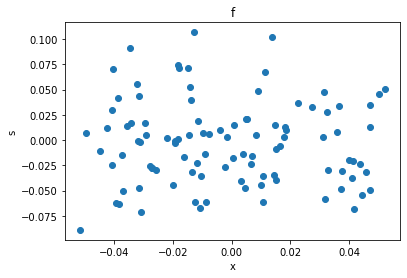

In [ ]:
plt.ion()
plt.show()
plt.clf()
plt.title('f')
plt.ylabel('s')
plt.xlabel('x')

tmpy = []
tmpx = []
for i in range(0, 100):
        tmpy.append(weights[0][0][i])
        tmpx.append(weights[0][1][i])

plt.scatter(tmpx, tmpy)   
plt.show()

### Evaluation on Test Set

In [ ]:
a = imdb.evaluate(x_test, y_test)
print("Accuarcy: ",a[1]*100)

782/782 [==============================] - 2s 3ms/step - loss: 1.5183 - acc: 0.8836
Accuarcy:  88.35600018501282


In [ ]:
a2 = imdb.evaluate(x_test, y_test)
print("Accuarcy: ",a2[1]*100)

782/782 [==============================] - 2s 2ms/step - loss: 0.9327 - acc: 0.8811
Accuarcy:  88.10799717903137


In [ ]:
prediction = imdb.predict(x_test)
y_pred = (prediction > 0.5)
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.879249421225783
Confusion matrix:


array([[11203,  1676],
       [ 1297, 10824]])